In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score as ras

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('pd_speech_features.csv')

In [3]:
df.shape

(756, 755)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


## Data Cleaning

In [6]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

In [ ]:
columns = list(df.columns)
for col in columns:
	if col == 'class':
		continue

	filtered_columns = [col]
	for col1 in df.columns:
		if((col == col1) | (col == 'class')):
			continue

		val = df[col].corr(df[col1])

		if val > 0.7:
			# If the correlation between the two
			# features is more than 0.7 remove
			columns.remove(col1)
			continue
		else:
			filtered_columns.append(col1)

	# After each iteration filter out the columns
	# which are not highly correlated features.
	df = df[filtered_columns]
df.shape

In [ ]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

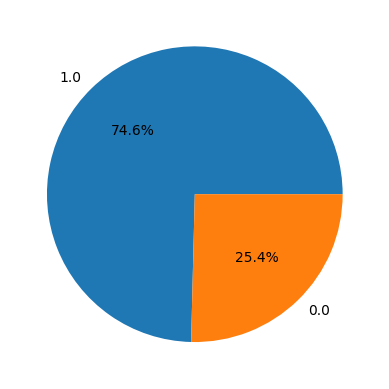

In [ ]:
x = df['class'].value_counts()
plt.pie(x.values,
		labels = x.index,
		autopct='%1.1f%%')
plt.show()

## Model Training

In [ ]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.2,
									random_state=10)
X_train.shape, X_val.shape

((201, 30), (51, 30))

In [ ]:
# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
						random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape

((302, 30), (302,))

In [ ]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(len(models)):
	models[i].fit(X, Y)

	print(f'{models[i]} : ')

	train_preds = models[i].predict_proba(X)[:, 1]
	print('Training Accuracy : ', ras(Y, train_preds))

	val_preds = models[i].predict_proba(X_val)[:, 1]
	print('Validation Accuracy : ', ras(Y_val, val_preds))
	print()

LogisticRegression() : 
Training Accuracy :  0.8292180167536511
Validation Accuracy :  0.8146718146718146

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9999999999999999
Validation Accuracy :  0.7857142857142857

SVC(probability=True) : 
Training Accuracy :  0.7

## Model Evaluation

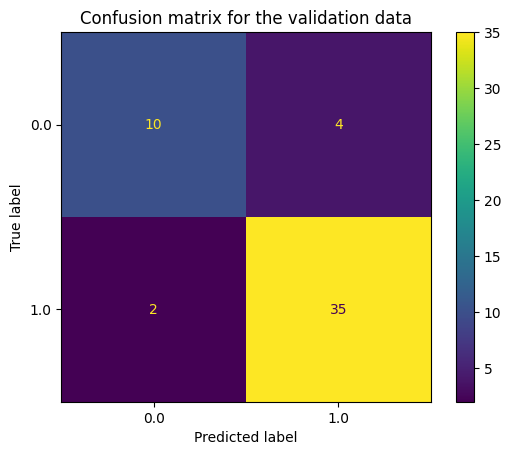

              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.90      0.95      0.92        37

    accuracy                           0.88        51
   macro avg       0.87      0.83      0.85        51
weighted avg       0.88      0.88      0.88        51



In [ ]:
metrics.ConfusionMatrixDisplay.from_estimator(models[0],
							                  X_val, Y_val)
plt.title('Confusion matrix for the validation data')
plt.show()
print(metrics.classification_report(
    Y_val, models[0].predict(X_val)))

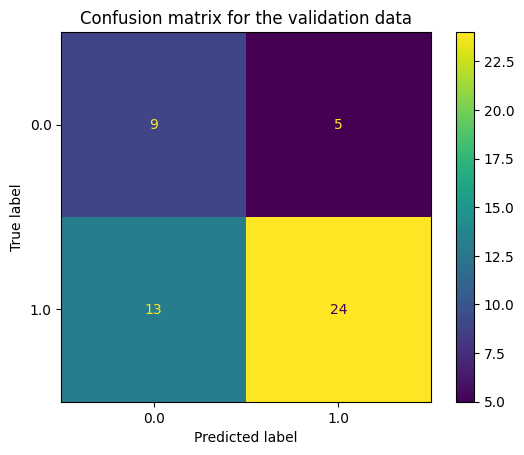

              precision    recall  f1-score   support

         0.0       0.41      0.64      0.50        14
         1.0       0.83      0.65      0.73        37

    accuracy                           0.65        51
   macro avg       0.62      0.65      0.61        51
weighted avg       0.71      0.65      0.66        51



In [ ]:
metrics.ConfusionMatrixDisplay.from_estimator(models[2],
							                  X_val, Y_val)
plt.title('Confusion matrix for the validation data')
plt.show()
print(metrics.classification_report(
    Y_val, models[2].predict(X_val)))